# Clustering Stocks Based On Value At Risk

Members of Teams
1. Abdullah Nasih Jasir (5025211111)
2. Mohammad Ahnaf Fauzan (5025211170)
3. Al-Ferro Yudisthira Putra (5025211176)

---
---
## **IMPORT LIBRARIES**
---
---

In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
from scipy.stats import norm
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

pd.set_option('display.max_rows', None)

---
---
## **PREPROCESSING**
---
---

### **Data Gathering**
The following code is useful for importing data from CSV files stored in the history folder

In [2]:
path = 'saham'
all_rec = glob.iglob(path + '/*.csv', recursive=True)
count = 0

prices_df = pd.DataFrame()
for f in all_rec:
    count = count + 1
    df = pd.read_csv(f, index_col='date', usecols=['date', 'close'])
    colname = os.path.basename(f).replace('.csv', '')
    df.rename(columns={'close': colname}, inplace=True)
    prices_df = pd.concat([prices_df, df], axis=1, sort=False)

# Convert the 'Date' column to datetime format
prices_df.index = pd.to_datetime(prices_df.index)

# Define the date range
start_date = pd.to_datetime("2022-03-24")
end_date = pd.to_datetime("2023-03-24")

# Filter the data to include only the specified date range
prices_df = prices_df[(prices_df.index >= start_date) & (prices_df.index <= end_date)]

# Filter stocks with at least 100 data points within the date range
valid_stocks = prices_df.columns[prices_df.count() >= 200]

# Create a new DataFrame with the selected date range and valid stocks
prices_train = prices_df.loc[(prices_df.index >= start_date) & (prices_df.index <= end_date),valid_stocks]
prices_train.head(10)

,ABBA,ABDA,ABMM,ACES,ACST,ADCP,ADES,ADHI,ADMF,ADMG,...,WSBP,WSKT,WTON,YELO,YPAS,YULE,ZBRA,ZINC,ZONE,ZYRX
date,,,,,,,,,,,,,,,,,,,,,
2022-03-24,300.0,6400.0,1670.0,995.0,197.0,94.0,3630.0,740.0,8400.0,181.0,...,95.0,570.0,222.0,121.0,452.0,2010.0,640.0,92.0,575.0,590.0
2022-03-25,296.0,6400.0,1625.0,1005.0,194.0,93.0,3630.0,735.0,8375.0,181.0,...,95.0,550.0,216.0,116.0,565.0,2010.0,615.0,91.0,595.0,600.0
2022-03-28,294.0,6400.0,1675.0,1015.0,192.0,93.0,3660.0,740.0,8375.0,184.0,...,95.0,555.0,216.0,114.0,705.0,2010.0,635.0,90.0,610.0,595.0
2022-03-29,294.0,6400.0,1680.0,1025.0,191.0,92.0,3680.0,740.0,8450.0,183.0,...,95.0,560.0,216.0,117.0,880.0,2010.0,600.0,90.0,600.0,565.0
2022-03-30,280.0,6400.0,1765.0,1025.0,191.0,92.0,3680.0,750.0,8550.0,181.0,...,95.0,555.0,218.0,116.0,1020.0,2020.0,630.0,90.0,630.0,600.0
2022-03-31,286.0,6400.0,1765.0,1025.0,193.0,90.0,3680.0,740.0,8575.0,184.0,...,95.0,550.0,218.0,114.0,950.0,2010.0,630.0,89.0,635.0,605.0
2022-04-01,284.0,6400.0,1780.0,1075.0,190.0,90.0,3680.0,725.0,8525.0,184.0,...,95.0,555.0,214.0,112.0,925.0,2020.0,625.0,90.0,630.0,600.0
2022-04-04,276.0,6400.0,1850.0,1110.0,190.0,90.0,3700.0,725.0,8650.0,184.0,...,95.0,550.0,216.0,113.0,980.0,2020.0,625.0,91.0,655.0,600.0
2022-04-05,284.0,6400.0,1975.0,1075.0,191.0,90.0,3690.0,730.0,8700.0,185.0,...,95.0,550.0,218.0,121.0,920.0,2020.0,625.0,92.0,680.0,580.0


### **Data Assessing**

In [3]:
prices_train.info(any)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2022-03-24 to 2023-03-24
Data columns (total 789 columns):
 #    Column  Dtype  
---   ------  -----  
 0    ABBA    float64
 1    ABDA    float64
 2    ABMM    float64
 3    ACES    float64
 4    ACST    float64
 5    ADCP    float64
 6    ADES    float64
 7    ADHI    float64
 8    ADMF    float64
 9    ADMG    float64
 10   ADMR    float64
 11   ADRO    float64
 12   AGAR    float64
 13   AGII    float64
 14   AGRO    float64
 15   AGRS    float64
 16   AHAP    float64
 17   AIMS    float64
 18   AISA    float64
 19   AKKU    float64
 20   AKPI    float64
 21   AKRA    float64
 22   AKSI    float64
 23   ALDO    float64
 24   ALKA    float64
 25   ALMI    float64
 26   ALTO    float64
 27   AMAG    float64
 28   AMAN    float64
 29   AMAR    float64
 30   AMFG    float64
 31   AMIN    float64
 32   AMOR    float64
 33   AMRT    float64
 34   ANDI    float64
 35   ANJT    float64
 36   ANTM    float64
 37   APEX    flo

In [4]:
prices_train.isnull().sum().sort_values(ascending=False)

ASHA     37
OLIV     30
WINR     21
IBOS     21
MTMH     18
TLDN     13
GOTO     12
SICO     11
WIRG      7
NUSA      0
NISP      0
NOBU      0
NPGF      0
NRCA      0
NTBK      0
NIRO      0
ABBA      0
OASA      0
NZIA      0
NIKL      0
OBMD      0
OCAP      0
OILS      0
OKAS      0
OMRE      0
OPMS      0
PADI      0
NIPS      0
NFCX      0
NICL      0
MYOR      0
MTDL      0
MTEL      0
MTFN      0
MTLA      0
MTPS      0
MTRA      0
MTSM      0
MTWI      0
MYOH      0
MYRX      0
NICK      0
MYRXP     0
MYTX      0
NANO      0
NASA      0
NASI      0
NATO      0
NELY      0
NETV      0
PAMG      0
PALM      0
PANI      0
MSIN      0
PNIN      0
PNSE      0
POLA      0
POLI      0
POLL      0
POLU      0
POLY      0
POOL      0
PORT      0
POSA      0
POWR      0
PPGL      0
PPRE      0
PPRO      0
PRAS      0
PRDA      0
PRIM      0
PSAB      0
PSDN      0
PSGO      0
PSKT      0
PSSI      0
PNLF      0
PNGO      0
PANR      0
PNBS      0
PANS      0
PBID      0
PBRX      0
PBSA

In [5]:
prices_train.duplicated().sum()

0

In [6]:
prices_train.describe()

,ABBA,ABDA,ABMM,ACES,ACST,ADCP,ADES,ADHI,ADMF,ADMG,...,WSBP,WSKT,WTON,YELO,YPAS,YULE,ZBRA,ZINC,ZONE,ZYRX
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,...,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,192.302419,6328.830645,3029.213710,675.935484,170.689516,73.955645,6530.241935,632.435484,8641.633065,163.141129,...,94.770161,459.770161,204.689516,86.104839,670.870968,2122.580645,555.080645,67.798387,1178.326613,435.427419
std,49.887985,337.636527,693.089287,204.219805,17.792449,6.735762,1149.832474,135.600075,639.974897,14.072119,...,1.950708,95.368662,18.955850,17.730241,95.935873,71.296507,30.401123,15.698309,210.959640,84.144966
min,92.000000,5500.000000,1625.000000,398.000000,123.000000,57.000000,3630.000000,402.000000,7925.000000,129.000000,...,73.000000,224.000000,160.000000,51.000000,452.000000,2010.000000,492.000000,50.000000,575.000000,286.000000
25%,151.750000,6050.000000,2487.500000,500.000000,159.000000,68.000000,6175.000000,495.500000,8118.750000,150.000000,...,95.000000,366.000000,194.000000,68.000000,625.000000,2090.000000,540.000000,50.000000,1125.000000,364.500000
50%,190.000000,6400.000000,2920.000000,627.500000,167.000000,74.000000,7037.500000,697.500000,8350.000000,166.000000,...,95.000000,498.000000,206.000000,91.000000,640.000000,2100.000000,550.000000,71.000000,1172.500000,450.000000
75%,227.000000,6700.000000,3502.500000,770.000000,181.000000,78.000000,7225.000000,740.000000,9000.000000,174.000000,...,95.000000,535.000000,214.000000,96.000000,690.000000,2140.000000,570.000000,81.000000,1226.250000,505.000000
max,300.000000,6725.000000,4850.000000,1170.000000,222.000000,94.000000,8100.000000,855.000000,10200.000000,187.000000,...,95.000000,585.000000,256.000000,122.000000,1020.000000,2410.000000,640.000000,96.000000,1810.000000,605.000000


### **Data Cleaning**

Since there are some columns that are not filled properly (with some empty rows), we decided to fill them in using linear interpolation. However, when we just use linear interpolation, the empty rows at the beginning cannot be filled since there is no number in front of the rows. Additionally, we add limit_direction='backward' to fully fill the last NaN

In [7]:
#Interpolate to fill in the data that is null
prices_train = prices_train.interpolate(method='linear', limit_direction='backward')
prices_train.isnull().sum().sort_values(ascending=False)


ABBA     0
NIKL     0
NIRO     0
NISP     0
NOBU     0
NPGF     0
NRCA     0
NTBK     0
NUSA     0
NZIA     0
OASA     0
OBMD     0
OCAP     0
OILS     0
OKAS     0
OLIV     0
OMRE     0
OPMS     0
PADI     0
PALM     0
PAMG     0
PANI     0
PANR     0
NIPS     0
NICL     0
MSIN     0
NICK     0
MTDL     0
MTEL     0
MTFN     0
MTLA     0
MTMH     0
MTPS     0
MTRA     0
MTSM     0
MTWI     0
MYOH     0
MYOR     0
MYRX     0
MYRXP    0
MYTX     0
NANO     0
NASA     0
NASI     0
NATO     0
NELY     0
NETV     0
NFCX     0
PANS     0
PBID     0
PBRX     0
PBSA     0
POLL     0
POLU     0
POLY     0
POOL     0
PORT     0
POSA     0
POWR     0
PPGL     0
PPRE     0
PPRO     0
PRAS     0
PRDA     0
PRIM     0
PSAB     0
PSDN     0
PSGO     0
PSKT     0
PSSI     0
PTBA     0
PTDU     0
PTIS     0
POLI     0
POLA     0
PNSE     0
PJAA     0
PCAR     0
PDES     0
PEGE     0
PEHA     0
PGAS     0
PGJO     0
PGLI     0
PGUN     0
PICO     0
PKPK     0
PNLF     0
PLAN     0
PLAS     0
PLIN     0

---
---
## **EXPLORATORY DATA ANALYSIS**
---
---

---
### **FINDING VALUE AT RISK**
---
To get the value of VaR, we need some work first, namely
1. Expected Values
2. Mean of Expected Values
3. Standard Deviation

### Expected Values
The following is the expected values ​​search algorithm

In [8]:
# Expected Value = Value(t) - Value(t-1) / Value(t-1)
expected_df = (prices_train.diff() / prices_train.shift(1)).shift(-1)
expected_df.columns = [f'{col}' for col in expected_df.columns]
expected_df.dropna(how='all', inplace=True)
expected_df.head()

,ABBA,ABDA,ABMM,ACES,ACST,ADCP,ADES,ADHI,ADMF,ADMG,...,WSBP,WSKT,WTON,YELO,YPAS,YULE,ZBRA,ZINC,ZONE,ZYRX
date,,,,,,,,,,,,,,,,,,,,,
2022-03-24,-0.013333,0.0,-0.026946,0.010050,-0.015228,-0.010638,0.000000,-0.006757,-0.002976,0.000000,...,0.0,-0.035088,-0.027027,-0.041322,0.250000,0.000000,-0.039062,-0.010870,0.034783,0.016949
2022-03-25,-0.006757,0.0,0.030769,0.009950,-0.010309,0.000000,0.008264,0.006803,0.000000,0.016575,...,0.0,0.009091,0.000000,-0.017241,0.247788,0.000000,0.032520,-0.010989,0.025210,-0.008333
2022-03-28,0.000000,0.0,0.002985,0.009852,-0.005208,-0.010753,0.005464,0.000000,0.008955,-0.005435,...,0.0,0.009009,0.000000,0.026316,0.248227,0.000000,-0.055118,0.000000,-0.016393,-0.050420
2022-03-29,-0.047619,0.0,0.050595,0.000000,0.000000,0.000000,0.000000,0.013514,0.011834,-0.010929,...,0.0,-0.008929,0.009259,-0.008547,0.159091,0.004975,0.050000,0.000000,0.050000,0.061947
2022-03-30,0.021429,0.0,0.000000,0.000000,0.010471,-0.021739,0.000000,-0.013333,0.002924,0.016575,...,0.0,-0.009009,0.000000,-0.017241,-0.068627,-0.004950,0.000000,-0.011111,0.007937,0.008333


### Mean Expected Value
The following is a search for mean expected values

In [9]:
# Calculate the mean (expected value) for each column in expected_df
expected_means = expected_df.mean()
expected_means.head()

ABBA   -0.003953
ABDA    0.000186
ABMM    0.002529
ACES   -0.002672
ACST   -0.001495
dtype: float64

### Standard Deviation
The following is a search for standard deviation

In [10]:
# Calculate the standard deviation of daily returns for each stock
std_deviation = expected_df.std()
std_deviation.head()

ABBA    0.037665
ABDA    0.016857
ABMM    0.036793
ACES    0.027626
ACST    0.020972
dtype: float64

### Value at Risk
Dengan memanfaatkan hasil dari pencarian di atas, kita mampu menemukan nilai value-at-risk sebagaimana ditunjukkan dibawah

In [11]:
# Calculate Value at Risk
value_at_risk = std_deviation.copy()
value_at_risk = -(expected_means + std_deviation*norm.ppf(0.01))
value_at_risk.head(10)

ABBA    0.091575
ABDA    0.039030
ABMM    0.083064
ACES    0.066941
ACST    0.050284
ADCP    0.056662
ADES    0.064534
ADHI    0.055274
ADMF    0.021519
ADMG    0.033812
dtype: float64

---
### **CLUSTERING**
---
After getting the VaR value, we will do clustering. There are several clustering methods used, namely,
1. K-Means Algorithm
2. Agglomerative Algorithm
3. Gaussian Mixture Model (GMM) Algorithm

### **Clustering K-Means**

### Elbow
Finding the right number of clustering using Elbow Methods

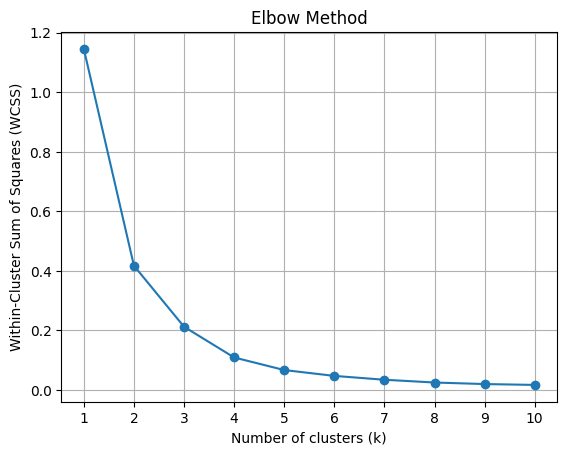

In [12]:
# Convert it to a DataFrame with a single column
Elbow = value_at_risk.to_frame()

# Initialize an empty list to store the within-cluster sum of squares (WCSS) for different values of k
wcss = []

# Define the range of k values to test
k_values = range(1, 11)  # Testing k values from 1 to 10

# Iterate over each value of k
for k in k_values:
    # Initialize KMeans with the current value of k
    kmeans = KMeans(n_clusters=k)
    
    # Fit KMeans to the data
    kmeans.fit(Elbow)
    
    # Append the WCSS (inertia_) to the list
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(np.arange(min(k_values), max(k_values)+1, 1.0))
plt.grid(True)
plt.show()

### K-Means Algorithm
The following code is useful for performing clustering using the K-Means method

In [13]:
# Number of Clusters
K = 5

# Reshape the pandas Series into a 2D array with a single column
X = value_at_risk.values.reshape(-1, 1)

# Perform K-means clustering
kmeans = KMeans(n_clusters=K, random_state=42)
clusters_kmeans = kmeans.fit_predict(X)
clusters_kmeans = clusters_kmeans + 1

# Display the resulting clusters
result_df_kmeans = pd.DataFrame({'VaR': value_at_risk, 'Cluster': clusters_kmeans})
print(result_df_kmeans)


            VaR  Cluster
ABBA   0.091575        2
ABDA   0.039030        1
ABMM   0.083064        2
ACES   0.066941        4
ACST   0.050284        1
ADCP   0.056662        4
ADES   0.064534        4
ADHI   0.055274        4
ADMF   0.021519        5
ADMG   0.033812        1
ADMR   0.090882        2
ADRO   0.061802        4
AGAR   0.077841        4
AGII   0.073007        4
AGRO   0.090780        2
AGRS   0.053244        4
AHAP   0.125475        3
AIMS   0.103093        2
AISA   0.055517        4
AKKU  -0.000000        5
AKPI   0.084875        2
AKRA   0.065403        4
AKSI   0.100126        2
ALDO   0.063784        4
ALKA   0.119332        3
ALMI   0.095687        2
ALTO   0.079956        4
AMAG   0.036565        1
AMAN   0.095255        2
AMAR   0.072511        4
AMFG   0.054981        4
AMIN   0.103884        2
AMOR   0.056338        4
AMRT   0.058271        4
ANDI  -0.000000        5
ANJT   0.043918        1
ANTM   0.059827        4
APEX   0.111599        2
APIC   0.022081        5


### Pin Point Graph of Every Stocks Based On K-Means Algorithm
The following code is useful for showing a stock distribution map based on Expected Values ​​and VaR

C:\Users\Abdullah NJ\AppData\Local\Temp\ipykernel_9860\3846397792.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab10', num_clusters)


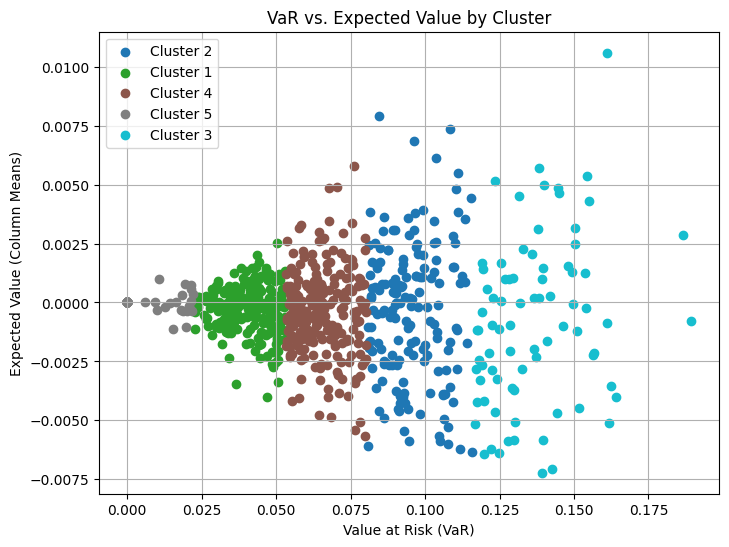

In [14]:
# Plot the graph for each cluster with a consistent color palette
plt.figure(figsize=(8, 6))
num_clusters = result_df_kmeans['Cluster'].nunique()
color_palette = plt.cm.get_cmap('tab10', num_clusters) 

for i, cluster in enumerate(result_df_kmeans['Cluster'].unique()):
    cluster_data_kmeans = result_df_kmeans[result_df_kmeans['Cluster'] == cluster]
    plt.scatter(
        cluster_data_kmeans['VaR'],
        expected_means[cluster_data_kmeans.index],
        color=color_palette(i),
        label=f'Cluster {cluster}' 
    )

plt.title('VaR vs. Expected Value by Cluster')
plt.xlabel('Value at Risk (VaR)')
plt.ylabel('Expected Value (Column Means)')
plt.legend()
plt.grid(True)
plt.show()

### Test Clustering Based On Selected Stocks on K-Means Algorithm

In [15]:
stock_name = "BBCA"
cluster_series = result_df_kmeans.loc[stock_name, 'Cluster'] if stock_name in result_df_kmeans.index else None

if cluster_series is not None:
    cluster = cluster_series
    print(f"The stock {stock_name} is in Cluster {cluster}\n")
    
    # Find stocks that are in the same cluster as the selected one
    same_cluster_stocks_kmeans = result_df_kmeans[result_df_kmeans['Cluster'] == cluster]

    # Display stocks that are in the same cluster as the selected one
    print(f"Other stocks in Cluster {cluster}:")
    print(same_cluster_stocks_kmeans.head(5))
else:
    print(f"The stock {stock_name} was not found in any cluster")

The stock BBCA is in Cluster 1

Other stocks in Cluster 1:
           VaR  Cluster
ABDA  0.039030        1
ACST  0.050284        1
ADMG  0.033812        1
AMAG  0.036565        1
ANJT  0.043918        1


### **Clustering Agglomerative Algorithm**

### Agglomerative Algorithm
The code below is useful for performing clustering based on the Agglomerative Algorithm

In [16]:
# Number of Clusters
K = 5

# Perform Agglomerative Clustering
agg_cluster = AgglomerativeClustering(n_clusters=K)
clusters_aglo = agg_cluster.fit_predict(value_at_risk.values.reshape(-1, 1))
clusters_aglo = clusters_aglo + 1

# Display the resulting clusters
result_df_aglo = pd.DataFrame({'VaR': value_at_risk, 'Cluster': clusters_aglo})
print(result_df_aglo)

            VaR  Cluster
ABBA   0.091575        2
ABDA   0.039030        4
ABMM   0.083064        2
ACES   0.066941        3
ACST   0.050284        3
ADCP   0.056662        3
ADES   0.064534        3
ADHI   0.055274        3
ADMF   0.021519        4
ADMG   0.033812        4
ADMR   0.090882        2
ADRO   0.061802        3
AGAR   0.077841        2
AGII   0.073007        3
AGRO   0.090780        2
AGRS   0.053244        3
AHAP   0.125475        1
AIMS   0.103093        1
AISA   0.055517        3
AKKU  -0.000000        5
AKPI   0.084875        2
AKRA   0.065403        3
AKSI   0.100126        2
ALDO   0.063784        3
ALKA   0.119332        1
ALMI   0.095687        2
ALTO   0.079956        2
AMAG   0.036565        4
AMAN   0.095255        2
AMAR   0.072511        3
AMFG   0.054981        3
AMIN   0.103884        1
AMOR   0.056338        3
AMRT   0.058271        3
ANDI  -0.000000        5
ANJT   0.043918        3
ANTM   0.059827        3
APEX   0.111599        1
APIC   0.022081        4


### Bar Plot Every Stocks Based On Agglomerative Algorithm
The code below is useful for visualizing distribution data based on Expected Values ​​and VaR from the Agglomerative algorithm

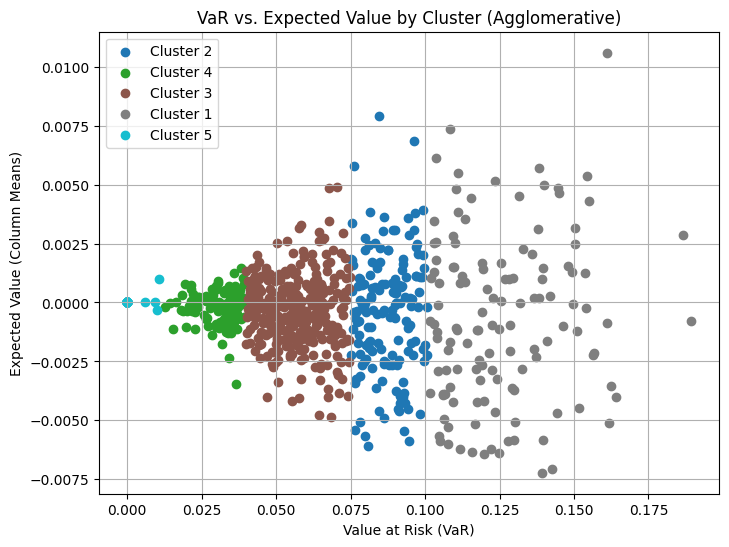

In [17]:
# Pick cluster count that is unique
num_clusters_aglo = result_df_aglo['Cluster'].nunique()

# Use the color palletes in order based on Matplotlib
color_palette_aglo = plt.cm.tab10(np.linspace(0, 1, num_clusters_aglo))

# Plot the graph for each cluster with a consistent color palette
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(result_df_aglo['Cluster'].unique()):
    cluster_data_aglo = result_df_aglo[result_df_aglo['Cluster'] == cluster]
    plt.scatter(
        cluster_data_aglo['VaR'],
        expected_means[cluster_data_aglo.index],
        color=color_palette_aglo[i], 
        label=f'Cluster {cluster}'
    )

plt.title('VaR vs. Expected Value by Cluster (Agglomerative)')
plt.xlabel('Value at Risk (VaR)')
plt.ylabel('Expected Value (Column Means)')
plt.legend()
plt.grid(True)
plt.show()

### Test Clustering Based On Selected Stocks on Agglomerative Algorithm

In [18]:
stock_name = "BBCA"
cluster_series_aglo = result_df_aglo.loc[stock_name, 'Cluster'] if stock_name in result_df_aglo.index else None

if cluster_series_aglo is not None:
    cluster_aglo = cluster_series_aglo
    print(f"The stock {stock_name} is in Cluster {cluster_aglo}\n")
    
    # Find stocks that are in the same cluster as the selected one
    same_cluster_stocks_aglo = result_df_aglo[result_df_aglo['Cluster'] == cluster_aglo]

    # Display stocks that are in the same cluster as the selected one
    print(f"Other stocks in Cluster {cluster_aglo}:")
    print(same_cluster_stocks_aglo.head(5))
else:
    print(f"The stock {stock_name} was not found in any cluster")

The stock BBCA is in Cluster 4

Other stocks in Cluster 4:
           VaR  Cluster
ABDA  0.039030        4
ADMF  0.021519        4
ADMG  0.033812        4
AMAG  0.036565        4
APIC  0.022081        4


### **Clustering GMM Algorithm**

### GMM Algorithm
The code below is useful for implementing the GMM algorithm in clustering

In [19]:
# Number of Clusters
K_gmm = 5

# Perform GMM Clustering
gmm_cluster = GaussianMixture(n_components=K_gmm, random_state=42)
clusters_gmm = gmm_cluster.fit_predict(value_at_risk.values.reshape(-1, 1))
clusters_gmm = clusters_gmm + 1

# Display the resulting clusters
result_df_gmm = pd.DataFrame({'VaR': value_at_risk, 'Cluster': clusters_gmm})
print(result_df_gmm)

            VaR  Cluster
ABBA   0.091575        2
ABDA   0.039030        1
ABMM   0.083064        2
ACES   0.066941        4
ACST   0.050284        1
ADCP   0.056662        4
ADES   0.064534        4
ADHI   0.055274        4
ADMF   0.021519        1
ADMG   0.033812        1
ADMR   0.090882        2
ADRO   0.061802        4
AGAR   0.077841        4
AGII   0.073007        4
AGRO   0.090780        2
AGRS   0.053244        4
AHAP   0.125475        3
AIMS   0.103093        2
AISA   0.055517        4
AKKU  -0.000000        5
AKPI   0.084875        2
AKRA   0.065403        4
AKSI   0.100126        2
ALDO   0.063784        4
ALKA   0.119332        3
ALMI   0.095687        2
ALTO   0.079956        2
AMAG   0.036565        1
AMAN   0.095255        2
AMAR   0.072511        4
AMFG   0.054981        4
AMIN   0.103884        2
AMOR   0.056338        4
AMRT   0.058271        4
ANDI  -0.000000        5
ANJT   0.043918        1
ANTM   0.059827        4
APEX   0.111599        2
APIC   0.022081        1


### Bar Plot Every Stocks Based On GMM Algorithm
The following is a visualization of all stocks based on Expected Values ​​and VaR from the GMM Algorithm

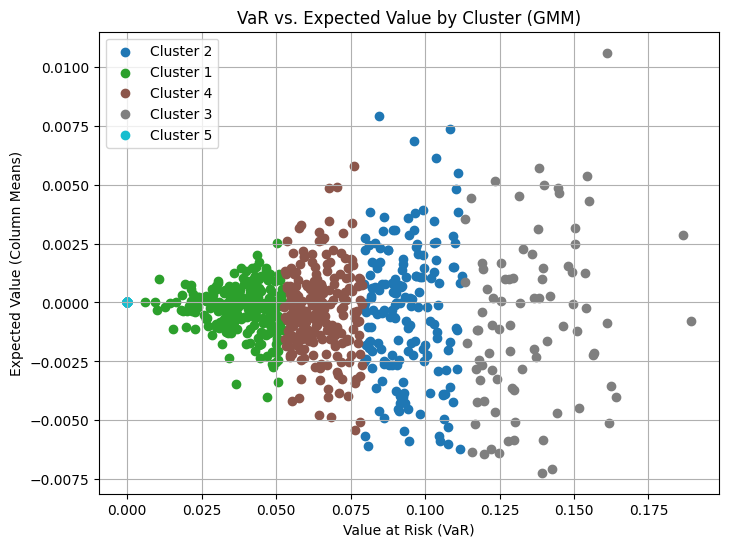

In [20]:
# Define colors for each cluster
num_clusters_gmm = len(result_df_gmm['Cluster'].unique())
color_palette_gmm = plt.cm.tab10(np.linspace(0, 1, num_clusters_gmm))

# Plot the graph for each cluster with a consistent color palette
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(result_df_gmm['Cluster'].unique()):
    cluster_data_gmm = result_df_gmm[result_df_gmm['Cluster'] == cluster]
    plt.scatter(
        cluster_data_gmm['VaR'],
        expected_means[cluster_data_gmm.index],
        color=color_palette_gmm[i], 
        label=f'Cluster {cluster}'
    )

plt.title('VaR vs. Expected Value by Cluster (GMM)')
plt.xlabel('Value at Risk (VaR)')
plt.ylabel('Expected Value (Column Means)')
plt.legend()
plt.grid(True)
plt.show()

### Test Clustering Based On Selected Stocks on GMM Algorithm

In [21]:
stock_name = "BBCA"
cluster_series_gmm = result_df_gmm.loc[stock_name, 'Cluster'] if stock_name in result_df_gmm.index else None

if cluster_series_gmm is not None:
    cluster_gmm = cluster_series_gmm
    print(f"The stock {stock_name} is in Cluster {cluster_gmm}\n")
    
    # Find stocks that are in the same cluster as the selected one
    same_cluster_stocks_gmm = result_df_gmm[result_df_gmm['Cluster'] == cluster_gmm]

    # Display stocks that are in the same cluster as the selected one
    print(f"Other stocks in Cluster {cluster_gmm}:")
    print(same_cluster_stocks_gmm.head(5))
else:
    print(f"The stock {stock_name} was not found in any cluster")

The stock BBCA is in Cluster 1

Other stocks in Cluster 1:
           VaR  Cluster
ABDA  0.039030        1
ACST  0.050284        1
ADMF  0.021519        1
ADMG  0.033812        1
AMAG  0.036565        1


---
### **COMPARISON**
---

### Mean VaR of Clusters Analysis Based On Algorithm
To find out the cluster similarities of each algorithm, it is necessary to carry out an analysis based on the mean VaR of each cluster

### K-Means Algorithm
The following is a visualization of the Mean VaR K-Means algorithm

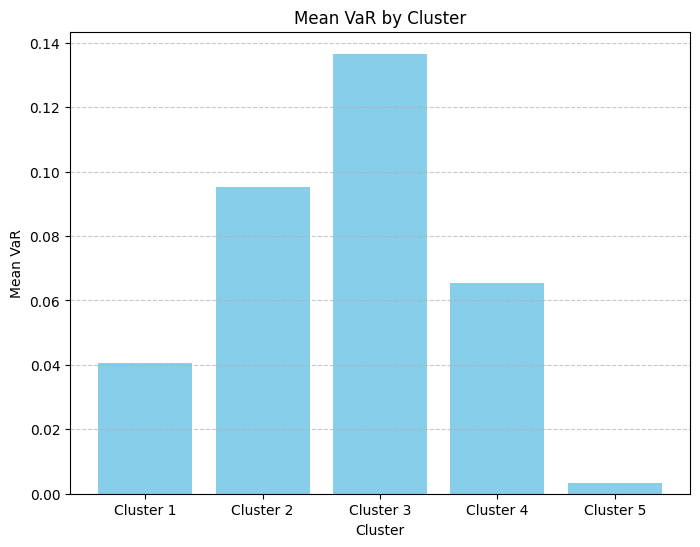

In [22]:
grouped_df_kmeans = result_df_kmeans.groupby('Cluster')['VaR'].mean().reset_index()
cluster_labels = [f'Cluster {label}' for label in grouped_df_kmeans['Cluster']]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(cluster_labels, grouped_df_kmeans['VaR'], color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Mean VaR')
plt.title('Mean VaR by Cluster')
plt.xticks(cluster_labels) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display plot
plt.show()

### Agglomerative Algorithm
The following is a visualization of the Mean VaR Aggloemerative algorithm

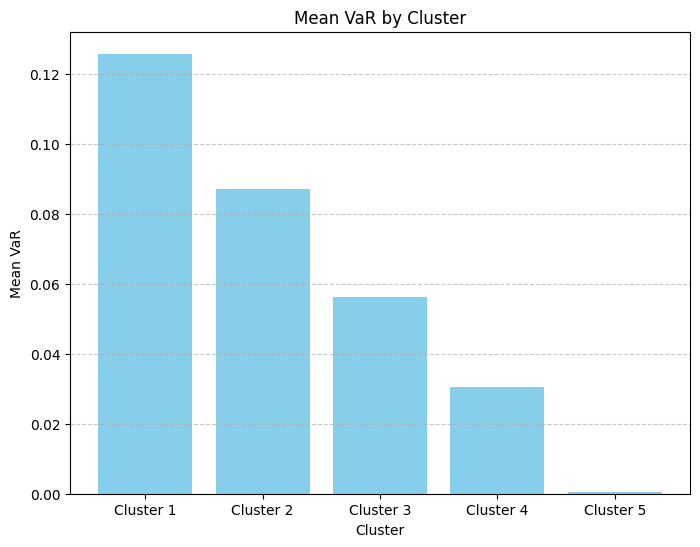

In [23]:
grouped_df_aglo = result_df_aglo.groupby('Cluster')['VaR'].mean().reset_index()
cluster_labels_aglo = [f'Cluster {label}' for label in grouped_df_aglo['Cluster']]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(cluster_labels_aglo, grouped_df_aglo['VaR'], color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Mean VaR')
plt.title('Mean VaR by Cluster')
plt.xticks(cluster_labels_aglo)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display plot
plt.show()

### GMM Algorithm
The following is a visualization of the Mean VaR GMM algorithm

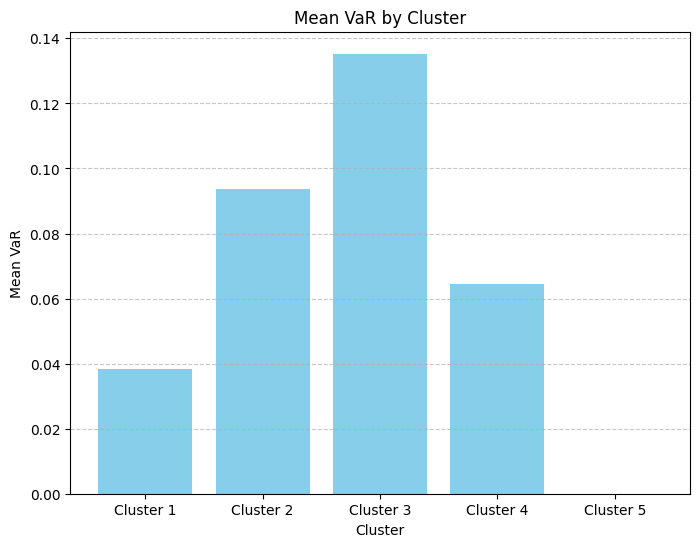

In [24]:
grouped_df_gmm = result_df_gmm.groupby('Cluster')['VaR'].mean().reset_index()
cluster_labels_gmm = [f'Cluster {label}' for label in grouped_df_gmm['Cluster']]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(cluster_labels_gmm, grouped_df_gmm['VaR'], color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Mean VaR')
plt.title('Mean VaR by Cluster')
plt.xticks(cluster_labels_gmm) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display plot
plt.show()

### Comparison of 3 Algorithms
The following is a comparison graph of Mean VaR for each cluster

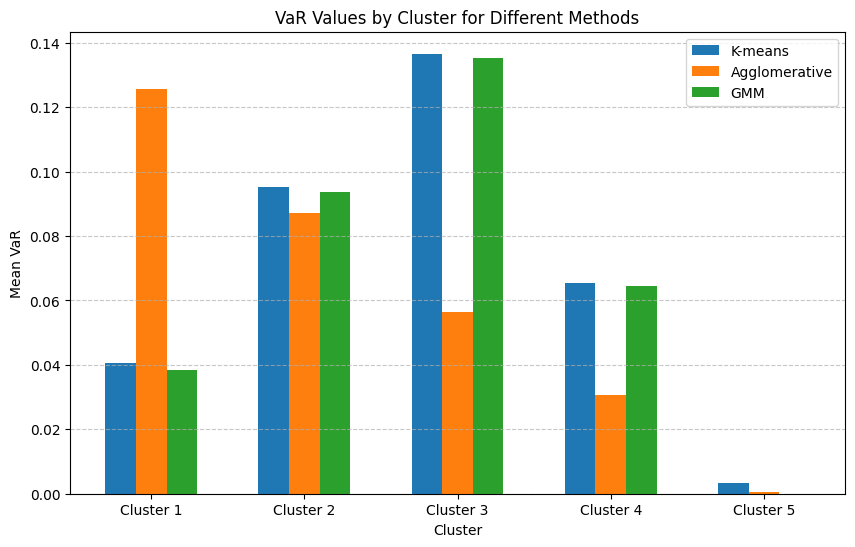

In [25]:
bar_width = 0.2

# Cluster position on x-axis
x_clusters = np.arange(len(grouped_df_kmeans))

plt.figure(figsize=(10, 6))

# Bar plot for K-means
plt.bar(x_clusters - bar_width, grouped_df_kmeans['VaR'], width=bar_width, label='K-means')

# Bar plot for Agglomerative clustering
plt.bar(x_clusters, grouped_df_aglo['VaR'], width=bar_width, label='Agglomerative')

# Bar plot ufor GMM
plt.bar(x_clusters + bar_width, grouped_df_gmm['VaR'], width=bar_width, label='GMM')

# Set labels and title
plt.xlabel('Cluster')
plt.ylabel('Mean VaR')
plt.title('VaR Values by Cluster for Different Methods')
plt.xticks(x_clusters, [f'Cluster {label}' for label in grouped_df_gmm['Cluster']])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display Plot
plt.show()


#### Note
Labeling clusters (in the form of 1, 2, 3, 4, or 5) in the data grouping process using certain algorithms does not always follow the order from lowest to highest risk. The naming of clusters in the grouping method tends to be random. However, each cluster from different algorithms still has similar characteristics, even though the labels given may vary.

### Cluster Sorting Based On The Mean VaR
In order to equate cluster names according to their characteristics, it is necessary to sort the clusters based on their Mean VaR value

In [26]:
def get_cluster_summary(df, algorithm_name):
    # Extract numeric columns
    numeric_columns = df.select_dtypes(include='number')
    
    # Calculate mean values for each cluster
    cluster_means = numeric_columns.groupby('Cluster').mean()['VaR']
    
    # Explicitly sort the mean values
    cluster_means_sorted = cluster_means.sort_values()
    
    # Create a DataFrame with mean values and cluster counts
    summary = pd.DataFrame({
        f'Mean VaR': cluster_means_sorted,
        f'Counts': df['Cluster'].value_counts().reindex(cluster_means_sorted.index)
    })
    
    return summary

# Get cluster summaries for each algorithm
kmeans_summary = get_cluster_summary(result_df_kmeans, 'K-Means')
aglo_summary = get_cluster_summary(result_df_aglo, 'Agglomerative')
gmm_summary = get_cluster_summary(result_df_gmm, 'GMM')

# Display the individual summaries
print("K-Means Cluster Summary:")
print(kmeans_summary)

print("\nAgglomerative Cluster Summary:")
print(aglo_summary)

print("\nGMM Cluster Summary:")
print(gmm_summary)

K-Means Cluster Summary:
         Mean VaR  Counts
Cluster                  
5        0.003423     105
1        0.040695     214
4        0.065416     226
2        0.095154     165
3        0.136598      79

Agglomerative Cluster Summary:
         Mean VaR  Counts
Cluster                  
5        0.000407      88
4        0.030603     107
3        0.056303     311
2        0.087090     157
1        0.125795     126

GMM Cluster Summary:
         Mean VaR  Counts
Cluster                  
5        0.000000      84
1        0.038340     231
4        0.064533     220
2        0.093687     170
3        0.135276      84


### Change of Cluster Order based On The Sorted Mean VaR
With the data obtained, we will change the cluster name to adjust the three algorithms

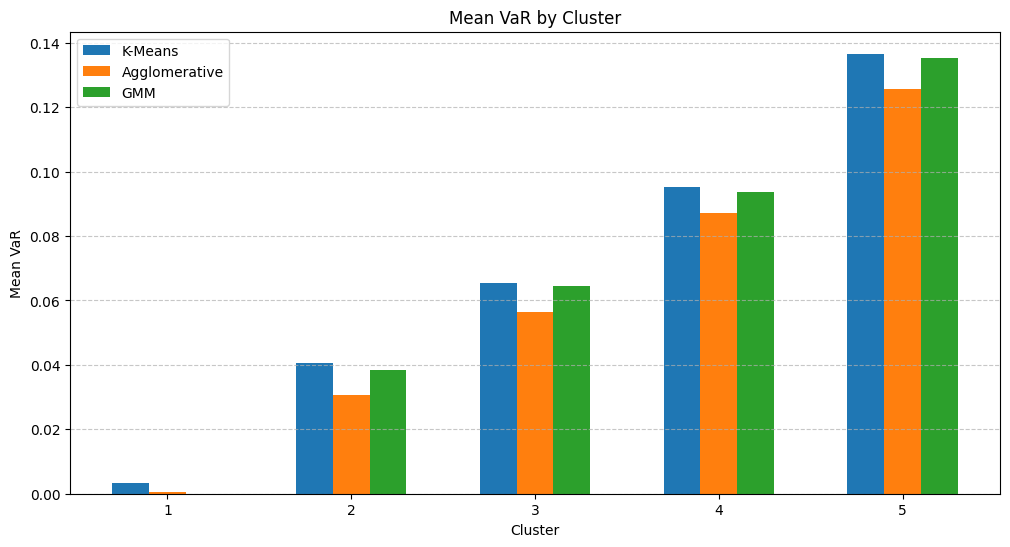

In [27]:
# Create copy of DataFrame without changing the original one
dfs = [result_df_kmeans, result_df_aglo, result_df_gmm]
new_dfs = [df.copy() for df in dfs]

# Determine the pattern of value subtitution
clusters = [kmeans_summary, aglo_summary, gmm_summary]

# Subtitute the value based on the pattern mentioned
for i, df in enumerate(new_dfs):
    df['Cluster'] = df['Cluster'].replace({clusters[i].index[j]: j+1 for j in range(5)})

# Save the result on the variable created earlier
newresult_df_kmeans, newresult_df_aglo, newresult_df_gmm = new_dfs

# Plot mean VaR for each cluster and algorithm after reassigning clusters
def get_cluster_summary(df, algorithm_name):
    numeric_columns = df.select_dtypes(include='number')
    cluster_means = numeric_columns.groupby('Cluster').mean()['VaR']
    cluster_means_sorted = cluster_means.sort_values()
    summary = pd.DataFrame({
        f'Mean VaR': cluster_means_sorted,
        f'Counts': df['Cluster'].value_counts().reindex(cluster_means_sorted.index)
    })
    return summary

# Get cluster summaries for each algorithm after reassigning clusters
new_kmeans_summary = get_cluster_summary(newresult_df_kmeans, 'K-Means')
new_aglo_summary = get_cluster_summary(newresult_df_aglo, 'Agglomerative')
new_gmm_summary = get_cluster_summary(newresult_df_gmm, 'GMM')

# Plot bar plot for mean VaR by cluster and algorithm after reassigning clusters
plt.figure(figsize=(12, 6))

bar_width = 0.2
x_kmeans = np.arange(len(new_kmeans_summary))
x_aglo = np.arange(len(new_aglo_summary)) + bar_width
x_gmm = np.arange(len(new_gmm_summary)) + 2 * bar_width

plt.bar(x_kmeans, new_kmeans_summary['Mean VaR'], width=bar_width, label='K-Means')
plt.bar(x_aglo, new_aglo_summary['Mean VaR'], width=bar_width, label='Agglomerative')
plt.bar(x_gmm, new_gmm_summary['Mean VaR'], width=bar_width, label='GMM')

plt.xlabel('Cluster')
plt.ylabel('Mean VaR')
plt.title('Mean VaR by Cluster')
plt.xticks(np.arange(len(new_gmm_summary)) + bar_width, new_gmm_summary.index)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


### Comparison of The Number of Stocks in Every Cluster
The following is an illustration of the number of stocks in each Cluster

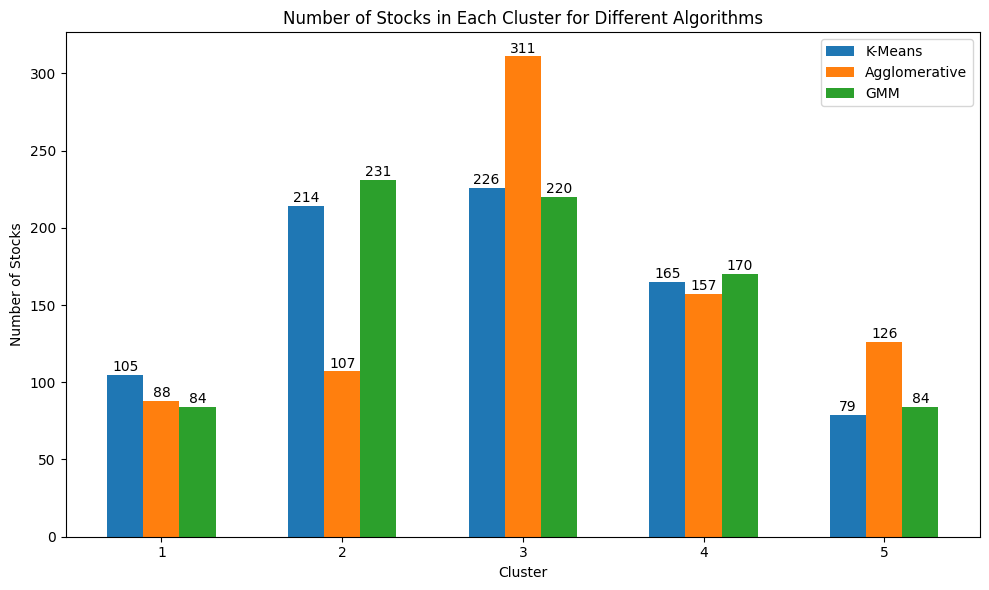

In [28]:
# Count the number of stocks in each cluster for each DataFrame
kmeans_cluster_counts = newresult_df_kmeans['Cluster'].value_counts().sort_index()
aglo_cluster_counts = newresult_df_aglo['Cluster'].value_counts().sort_index()
gmm_cluster_counts = newresult_df_gmm['Cluster'].value_counts().sort_index()

# Create a bar plot to compare the number of stocks in each cluster for each algorithm
plt.figure(figsize=(10, 6))

bar_width = 0.2
index = kmeans_cluster_counts.index  

plt.bar(index - bar_width, kmeans_cluster_counts, width=bar_width, label='K-Means')
plt.bar(index, aglo_cluster_counts, width=bar_width, label='Agglomerative')
plt.bar(index + bar_width, gmm_cluster_counts, width=bar_width, label='GMM')

# Display count values on top of each bar
for i, v in enumerate(kmeans_cluster_counts):
    plt.text(i + 1 - bar_width, v + 0.5, str(v), ha='center', va='bottom')
for i, v in enumerate(aglo_cluster_counts):
    plt.text(i+1, v + 0.5, str(v), ha='center', va='bottom')
for i, v in enumerate(gmm_cluster_counts):
    plt.text(i + 1 + bar_width, v + 0.5, str(v), ha='center', va='bottom')

plt.xlabel('Cluster')
plt.ylabel('Number of Stocks')
plt.title('Number of Stocks in Each Cluster for Different Algorithms')
plt.xticks(index)
plt.legend()
plt.tight_layout()
plt.show()


---
### **RESULT**
---

### Stock Cluster 1
The following is Stock data that is in cluster 1 in each algorithm

In [29]:
newresult_df_kmeans['Stocks'] = newresult_df_kmeans.index
newresult_df_aglo['Stocks'] = newresult_df_aglo.index
newresult_df_gmm['Stocks'] = newresult_df_gmm.index

# Choose stocks with the cluster of 1 in each algorithm
stocks_kmeans_cluster1 = newresult_df_kmeans[newresult_df_kmeans['Cluster'] == 1]['Stocks']
stocks_aglo_cluster1 = newresult_df_aglo[newresult_df_aglo['Cluster'] == 1]['Stocks']
stocks_gmm_cluster1 = newresult_df_gmm[newresult_df_gmm['Cluster'] == 1]['Stocks']

# Find stocks that are in the cluster 1 on every algorithm
stocks_in_clusters1 = set(stocks_kmeans_cluster1) & set(stocks_aglo_cluster1) & set(stocks_gmm_cluster1)

#  Display and Check if the stocks are in the same cluster on every algorithm
print("Stock berikut memiliki cluster 1 di ketiga algoritma:")
print(', '.join(f"'{stock}'" for stock in stocks_in_clusters1))

Stock berikut memiliki cluster 1 di ketiga algoritma:
'SMRU', 'SKYB', 'IKAI', 'DEAL', 'SBAT', 'OCAP', 'IIKP', 'KPAL', 'BAPI', 'GOLL', 'CNTB', 'JGLE', 'AKKU', 'SRIL', 'KIAS', 'SUGI', 'ELTY', 'EPAC', 'JKSW', 'PLAS', 'HDTX', 'MYRX', 'BEKS', 'FORZ', 'RONY', 'SCPI', 'MAGP', 'MAMIP', 'KBRI', 'KRAH', 'MABA', 'HADE', 'ARMY', 'GAMA', 'IBFN', 'ARTI', 'POSA', 'SIMA', 'MGNA', 'TAMU', 'RIMO', 'NASA', 'HOME', 'COWL', 'TOPS', 'POOL', 'MDRN', 'TRIO', 'KOTA', 'TARA', 'CTTH', 'MTFN', 'KPAS', 'VIVA', 'CNKO', 'BLTA', 'MAMI', 'DPUM', 'DUCK', 'MIRA', 'LCGP', 'CPRI', 'BTEK', 'DADA', 'ANDI', 'PADI', 'TDPM', 'MYRXP', 'NUSA', 'DEFI', 'BUVA', 'TAXI', 'BTEL', 'HOTL', 'HKMU', 'ENVY', 'RMBA', 'LAPD', 'NIPS', 'TRAM', 'UNIT', 'MKNT', 'MTRA', 'TRIL'


### Stock Cluster 2
The following is Stock data that is in cluster 2 in each algorithm

In [30]:
# Choose stocks with the cluster of 2 in each algorithm
stocks_kmeans_cluster2 = newresult_df_kmeans[newresult_df_kmeans['Cluster'] == 2]['Stocks']
stocks_aglo_cluster2 = newresult_df_aglo[newresult_df_aglo['Cluster'] == 2]['Stocks']
stocks_gmm_cluster2 = newresult_df_gmm[newresult_df_gmm['Cluster'] == 2]['Stocks']

# Find stocks that are in the cluster 2 on every algorithm
stocks_in_clusters2 = set(stocks_kmeans_cluster2) & set(stocks_aglo_cluster2) & set(stocks_gmm_cluster2)

# Display and Check if the stocks are in the same cluster on every algorithm
print("Stock berikut memiliki cluster 2 di ketiga algoritma:")
print(', '.join(f"'{stock}'" for stock in stocks_in_clusters2))

Stock berikut memiliki cluster 2 di ketiga algoritma:
'TOTL', 'NISP', 'PZZA', 'MASB', 'ASDM', 'UNIC', 'TAMA', 'SPTO', 'HRME', 'SDRA', 'TRST', 'MCOR', 'SOHO', 'AMAG', 'PURE', 'MGRO', 'SMAR', 'WEGE', 'ZBRA', 'CBMF', 'FASW', 'UCID', 'INDF', 'BBNI', 'DEPO', 'PNGO', 'ASGR', 'MTEL', 'INDS', 'SCCO', 'ARKA', 'MAIN', 'CARE', 'MERK', 'ROTI', 'CLPI', 'DMAS', 'GWSA', 'CASA', 'BBCA', 'BBRI', 'BINA', 'YULE', 'BNGA', 'PANS', 'ADMG', 'DVLA', 'ULTJ', 'MLBI', 'SGRO', 'ICBP', 'BIPP', 'BNII', 'DCII', 'DNET', 'TELE', 'BHAT', 'FAST', 'TBLA', 'GJTL', 'BINO', 'WOWS', 'SMCB', 'POWR', 'SMMA', 'ABDA', 'IPCM', 'DMND', 'JSMR', 'ZINC', 'DPNS', 'CCSI', 'TLDN', 'BTPN', 'PPRO', 'TLKM', 'BSWD', 'SRSN', 'MYOH', 'ARNA', 'BNLI', 'HEXA', 'SOCI', 'NATO', 'PTSN', 'SIMP', 'BSDE', 'EPMT', 'NTBK', 'NRCA'


### Stock Cluster 3
The following is Stock data that is in cluster 3 in each algorithm

In [31]:
# Choose stocks with the cluster of 3 in each algorithm
stocks_kmeans_cluster3 = newresult_df_kmeans[newresult_df_kmeans['Cluster'] == 3]['Stocks']
stocks_aglo_cluster3 = newresult_df_aglo[newresult_df_aglo['Cluster'] == 3]['Stocks']
stocks_gmm_cluster3 = newresult_df_gmm[newresult_df_gmm['Cluster'] == 3]['Stocks']

# Find stocks that are in the cluster 3 on every algorithm
stocks_in_clusters3 = set(stocks_kmeans_cluster3) & set(stocks_aglo_cluster3) & set(stocks_gmm_cluster3)

#  Display and Check if the stocks are in the same cluster on every algorithm
print("Stock berikut memiliki cluster 3 di ketiga algoritma:")
print(', '.join(f"'{stock}'" for stock in stocks_in_clusters3))

Stock berikut memiliki cluster 3 di ketiga algoritma:
'INOV', 'TCPI', 'PLAN', 'LINK', 'ALDO', 'INCO', 'STTP', 'LPLI', 'LUCK', 'KPIG', 'DSNG', 'BALI', 'GEMA', 'MCAS', 'KEEN', 'SRTG', 'CPRO', 'DKFT', 'PAMG', 'ADCP', 'BUKK', 'GTSI', 'AMAR', 'WSKT', 'POLY', 'ADRO', 'EMTK', 'GEMS', 'POLI', 'BMTR', 'AGII', 'APII', 'MINA', 'AMRT', 'BIKE', 'WMUU', 'MBTO', 'BUDI', 'ACES', 'KINO', 'BGTG', 'SKLT', 'FISH', 'RODA', 'TGKA', 'KOIN', 'SAME', 'IPTV', 'SATU', 'DNAR', 'LPIN', 'CFIN', 'SMRA', 'ADES', 'PPGL', 'ARTA', 'BTON', 'RISE', 'IMJS', 'TEBE', 'PMJS', 'MSKY', 'WOOD', 'FLMC', 'INDY', 'ADHI', 'BFIN', 'KMDS', 'DILD', 'CLEO', 'PSSI', 'MOLI', 'VOKS', 'RANC', 'GPRA', 'NOBU', 'TIRA', 'MBAP', 'PTBA', 'BTPS', 'SPMA', 'CITY', 'IKBI', 'BSSR', 'ZONE', 'TGRA', 'BEST', 'JIHD', 'SAFE', 'SMKL', 'IKAN', 'LPPF', 'GLVA', 'CSRA', 'ISAT', 'WIFI', 'KREN', 'BRAM', 'DGIK', 'DRMA', 'BEEF', 'JAST', 'MAPI', 'NELY', 'MAPA', 'TOTO', 'GGRP', 'TINS', 'LPPS', 'ITMG', 'PGJO', 'DART', 'DSSA', 'MPMX', 'SCMA', 'AMOR', 'MKPI', 'BISI', 'S

### Stock Cluster 4
The following is Stock data that is in cluster 4 in each algorithm

In [32]:
# Choose stocks with the cluster of 4 in each algorithm
stocks_kmeans_cluster4 = newresult_df_kmeans[newresult_df_kmeans['Cluster'] == 4]['Stocks']
stocks_aglo_cluster4 = newresult_df_aglo[newresult_df_aglo['Cluster'] == 4]['Stocks']
stocks_gmm_cluster4 = newresult_df_gmm[newresult_df_gmm['Cluster'] == 4]['Stocks']

# Find stocks that are in the cluster 4 on every algorithm
stocks_in_clusters4 = set(stocks_kmeans_cluster4) & set(stocks_aglo_cluster4) & set(stocks_gmm_cluster4)

#  Display and Check if the stocks are in the same cluster on every algorithm
print("Stock berikut memiliki cluster 4 di ketiga algoritma:")
print(', '.join(f"'{stock}'" for stock in stocks_in_clusters4))

Stock berikut memiliki cluster 4 di ketiga algoritma:
'MDLN', 'BRMS', 'ENZO', 'MPOW', 'SQMI', 'ESSA', 'WMPP', 'RDTX', 'WINS', 'SBMA', 'RELI', 'YELO', 'OLIV', 'INDO', 'MITI', 'LUCY', 'NFCX', 'SIPD', 'IATA', 'IFSH', 'BABP', 'UVCR', 'RAJA', 'KARW', 'WEHA', 'SEMA', 'JAWA', 'KOBX', 'NICK', 'BBLD', 'IBOS', 'ASSA', 'MREI', 'RIGS', 'BBSS', 'PNBS', 'JECC', 'PANR', 'ENRG', 'DIGI', 'MASA', 'PCAR', 'DAYA', 'SUPR', 'CTBN', 'BNBR', 'SAPX', 'ABBA', 'DOID', 'CNTX', 'PEGE', 'IPAC', 'TMAS', 'ETWA', 'BUMI', 'BBRM', 'ALMI', 'KBLM', 'KBLV', 'IDEA', 'FPNI', 'LEAD', 'OPMS', 'PNBN', 'BANK', 'SOTS', 'INCF', 'ABMM', 'INPP', 'LCKM', 'HAIS', 'ERTX', 'GLOB', 'FITT', 'FILM', 'BOLA', 'BRNA', 'AGRO', 'TRJA', 'TOYS', 'PKPK', 'ASPI', 'TMPO', 'LPGI', 'ATAP', 'PNLF', 'RUIS', 'TALF', 'BCIC', 'NETV', 'UNIQ', 'JAYA', 'BLTZ', 'CAKK', 'AKSI', 'CENT', 'RMKE', 'SHIP', 'BMAS', 'SMMT', 'DWGL', 'TUGU', 'DEWA', 'NANO', 'PNIN', 'BAJA', 'ROCK', 'META', 'AMAN', 'CASH', 'PBSA', 'BBHI', 'RUNS', 'DMMX', 'VINS', 'AKPI', 'PSDN', 'ADMR'


### Stock Cluster 5
The following is Stock data that is in cluster 5 in each algorithm

In [33]:
# Choose stocks with the cluster of 5 in each algorithm
stocks_kmeans_cluster5 = newresult_df_kmeans[newresult_df_kmeans['Cluster'] == 5]['Stocks']
stocks_aglo_cluster5 = newresult_df_aglo[newresult_df_aglo['Cluster'] == 5]['Stocks']
stocks_gmm_cluster5 = newresult_df_gmm[newresult_df_gmm['Cluster'] == 5]['Stocks']

# Find stocks that are in the cluster 5 on every algorithm
stocks_in_clusters5 = set(stocks_kmeans_cluster5) & set(stocks_aglo_cluster5) & set(stocks_gmm_cluster5)

#  Display and Check if the stocks are in the same cluster on every algorithm
print("Stock berikut memiliki cluster 5 di ketiga algoritma:")
print(', '.join(f"'{stock}'" for stock in stocks_in_clusters5))

Stock berikut memiliki cluster 5 di ketiga algoritma:
'POLU', 'AYLS', 'PBRX', 'HDIT', 'GZCO', 'KJEN', 'JTPE', 'YPAS', 'BMSR', 'NZIA', 'BAPA', 'SLIS', 'TPIA', 'POLL', 'ALKA', 'WIRG', 'KONI', 'SDPC', 'HITS', 'MIDI', 'OASA', 'BOSS', 'HRUM', 'MTWI', 'PANI', 'ASMI', 'BIMA', 'PICO', 'BELL', 'BPTR', 'FORU', 'OMRE', 'PGUN', 'AHAP', 'HDFA', 'SDMU', 'PTDU', 'BEBS', 'TAYS', 'TFAS', 'BSML', 'UANG', 'LAND', 'OKAS', 'INTD', 'SGER', 'EKAD', 'MGLV', 'HOPE', 'SICO', 'HOMI', 'IPPE', 'FMII', 'PURI', 'TNCA', 'FIRE', 'DFAM', 'KIOS', 'WINR', 'MLIA', 'ESTA', 'INPS', 'TRIS', 'PTIS', 'SULI', 'SILO', 'MTSM', 'MTPS', 'SMDR', 'WAPO', 'SINI', 'UFOE', 'ASHA', 'SKRN', 'INDX', 'PGLI', 'BYAN', 'ARTO', 'GPSO'


---
### **FEATURES**
---

### Note
Value at Risk (VaR) is a method for estimating the potential loss of an investment with a certain level of confidence. For example, with a VaR of 0.56 at a 99% confidence level, there is a 99% probability that investment losses will not exceed 56% in a given period.

In general, the lower the VaR value, the more stable and less volatile the stock price, indicating lower risk. Conversely, the higher the VaR value, the greater the share price fluctuations, indicating a higher level of risk in daily stock price changes.

### Merging All The Clusters Into One Data Frame
The code below is useful for unifying all clusters into one dataframe

In [34]:
# Merge three DataFrame based on 'Stock' and 'Cluster' Columns
finalresult_df = pd.merge(newresult_df_kmeans, newresult_df_aglo, on=['VaR', 'Stocks', 'Cluster'])
finalresult_df = pd.merge(finalresult_df, newresult_df_gmm, on=['VaR', 'Stocks', 'Cluster'])

print(finalresult_df)

          VaR  Cluster Stocks
0    0.091575        4   ABBA
1    0.039030        2   ABDA
2    0.083064        4   ABMM
3    0.066941        3   ACES
4    0.056662        3   ADCP
5    0.064534        3   ADES
6    0.055274        3   ADHI
7    0.033812        2   ADMG
8    0.090882        4   ADMR
9    0.061802        3   ADRO
10   0.073007        3   AGII
11   0.090780        4   AGRO
12   0.053244        3   AGRS
13   0.125475        5   AHAP
14   0.055517        3   AISA
15  -0.000000        1   AKKU
16   0.084875        4   AKPI
17   0.065403        3   AKRA
18   0.100126        4   AKSI
19   0.063784        3   ALDO
20   0.119332        5   ALKA
21   0.095687        4   ALMI
22   0.036565        2   AMAG
23   0.095255        4   AMAN
24   0.072511        3   AMAR
25   0.054981        3   AMFG
26   0.056338        3   AMOR
27   0.058271        3   AMRT
28  -0.000000        1   ANDI
29   0.059827        3   ANTM
30   0.074579        3   APII
31   0.037020        2   ARKA
32  -0.000

### **Feature 1**
#### Testing a specific Stock to where it falls in cluster while also recommending some stocks that fall in the same cluster.

Saham BBCA berada pada Cluster 2
Cluster 2: Investasi dalam klaster ini memiliki risiko yang Rendah.

5 saham dengan Resiko Terendah di Cluster 2:
          VaR Stocks  Cluster
465  0.022629   SMCB        2
492  0.022907   TAMA        2
528  0.022930   ULTJ        2
176  0.023219   EPMT        2
449  0.023810   SDRA        2



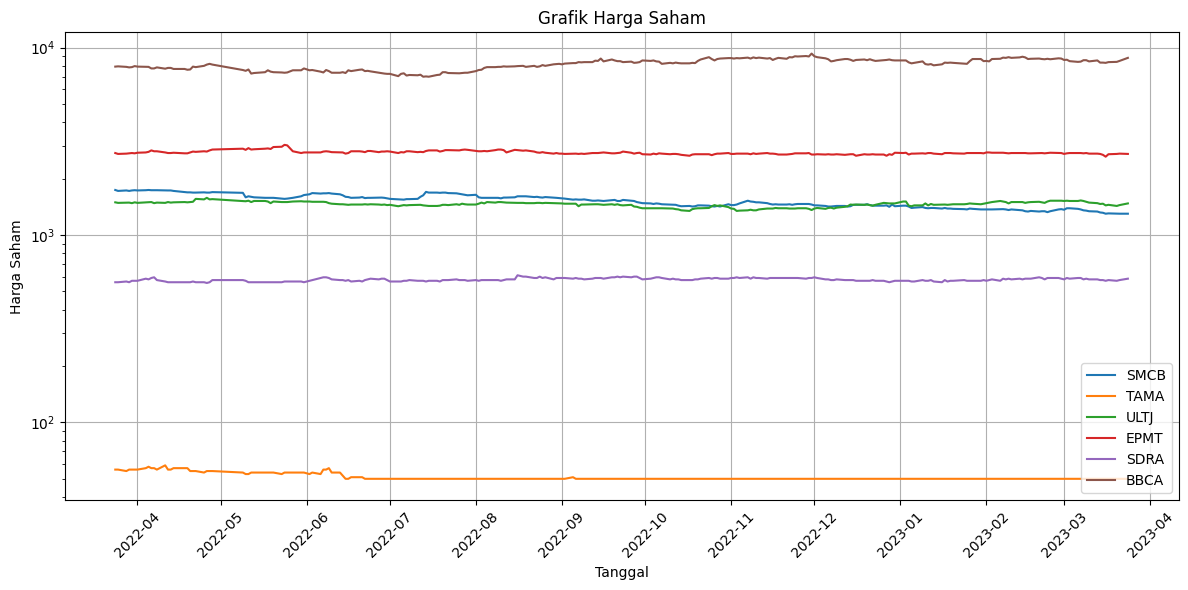

In [35]:
def print_cluster_info(cluster, cluster_data):
    risk_levels = {
        1: "Sangat Rendah",
        2: "Rendah",
        3: "Sedang",
        4: "Tinggi",
        5: "Sangat Tinggi"
    }

    print(f"Cluster {cluster}: Investasi dalam klaster ini memiliki risiko yang {risk_levels.get(cluster, 'tidak dikenal')}.\n")

    top_5_highest_var = cluster_data.head(5)
    
    print(f"5 saham dengan Resiko Terendah di Cluster {cluster}:")
    print(top_5_highest_var[['VaR', 'Stocks', 'Cluster']], end='\n\n')

stock_name = "BBCA"
cluster_final = finalresult_df[finalresult_df.Stocks == stock_name]['Cluster']

if not cluster_final.empty:
    clusters_found = cluster_final.unique()
    cluster_data_dict = {}

    for cluster in clusters_found:
        print(f"Saham {stock_name} berada pada Cluster {cluster}")
        same_cluster_final = finalresult_df[finalresult_df['Cluster'] == cluster]
        sorted_cluster = same_cluster_final.sort_values(by='VaR', ascending=True)
        cluster_data_dict[cluster] = sorted_cluster.head(5)

        print_cluster_info(cluster, cluster_data_dict[cluster])

    additional_stocksfix = [cluster_data['Stocks'].tolist() for cluster_data in cluster_data_dict.values()]
    stocks_to_plot = [item for sublist in additional_stocksfix for item in sublist] + [stock_name]

    selected_stocks = prices_df[stocks_to_plot]

    plt.figure(figsize=(12, 6))
    for stock in stocks_to_plot:
        plt.semilogy(selected_stocks.index, selected_stocks[stock], label=stock)

    plt.title('Grafik Harga Saham')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga Saham')
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    print(f"Saham {stock_name} tidak ditemukan di cluster manapun")

### **Feature 2**
#### Giving some stocks recommendation depending on the cluster risk level.

In [36]:
# Memilih tingkat risiko
tingkat_resiko = "Tinggi"

# Dictionary for the mapping of the risk level
tingkat_resiko_to_cluster = {
    "Sangat Rendah": 1,
    "Rendah": 2,
    "Sedang": 3,
    "Tinggi": 4,
    "Sangat Tinggi": 5
}

# Check if the result is valid
if tingkat_resiko in tingkat_resiko_to_cluster:
    cluster = tingkat_resiko_to_cluster[tingkat_resiko]
    emiten_cluster = finalresult_df[finalresult_df['Cluster'] == cluster]['Stocks']
    
    if not emiten_cluster.empty:
        if len(emiten_cluster) < 10:
            print(f"Rekomendasi emiten untuk tingkat Risiko '{tingkat_resiko}':")
            for emiten in emiten_cluster:
                print(emiten)
        else:
            emiten_rekomendasi = random.sample(emiten_cluster.tolist(), k=10)
            print(f"Rekomendasi 10 emiten untuk tingkat Risiko '{tingkat_resiko}':")
            for emiten in emiten_rekomendasi:
                print(emiten)
    else:
        print(f"Tidak ada emiten untuk tingkat Risiko '{tingkat_resiko}'")
else:
    print("Tingkat risiko tidak valid")


Rekomendasi 10 emiten untuk tingkat Risiko 'Tinggi':
PNBS
TMAS
BABP
CAKK
ENRG
PKPK
TALF
ROCK
MREI
UVCR


---
---
## **EVALUATION**
---
---


### Silhouette Score

Silhouette Score K-Means: 0.5719209125826348
Silhouette Score GMM: 0.563363428322348
Silhouette Score Agglomerative Clustering: 0.5312060361987404


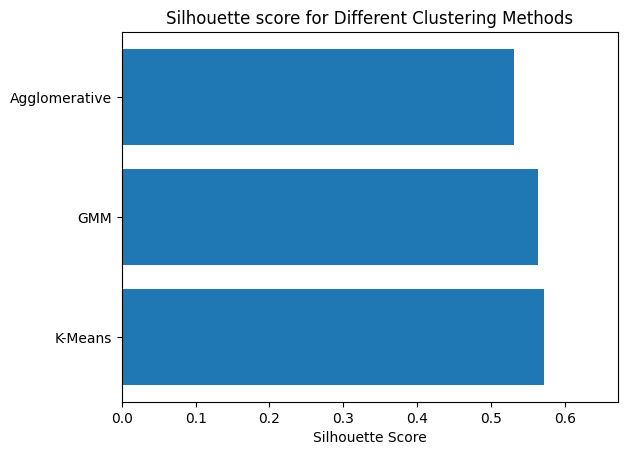

In [37]:
# Take the result of clustering from the all the algorithms
test1_clusters_kmeans = result_df_kmeans['Cluster']  # Clustering result of K-Means
test1_clusters_gmm = result_df_gmm['Cluster']   # Clustering result of GMM
test1_clusters_aglo = result_df_aglo['Cluster']   # Clustering result of Agglomerical

# Count the silhouette score of every clustering method
silhouette_kmeans = silhouette_score(value_at_risk.values.reshape(-1, 1), test1_clusters_kmeans)
silhouette_gmm = silhouette_score(value_at_risk.values.reshape(-1, 1), test1_clusters_gmm)
silhouette_aglo = silhouette_score(value_at_risk.values.reshape(-1, 1), test1_clusters_aglo)

# Display the result
print(f"Silhouette Score K-Means: {silhouette_kmeans}")
print(f"Silhouette Score GMM: {silhouette_gmm}")
print(f"Silhouette Score Agglomerative Clustering: {silhouette_aglo}")

methods = ['K-Means', 'GMM', 'Agglomerative']
scores = [silhouette_kmeans, silhouette_gmm, silhouette_aglo]

# Create a bar chart
plt.barh(methods, scores)
plt.xlabel('Silhouette Score')
plt.title('Silhouette score for Different Clustering Methods')
plt.xlim([0, max(scores) + 0.1])  # Adjust the x-axis limits if needed

# Display the plot
plt.show()

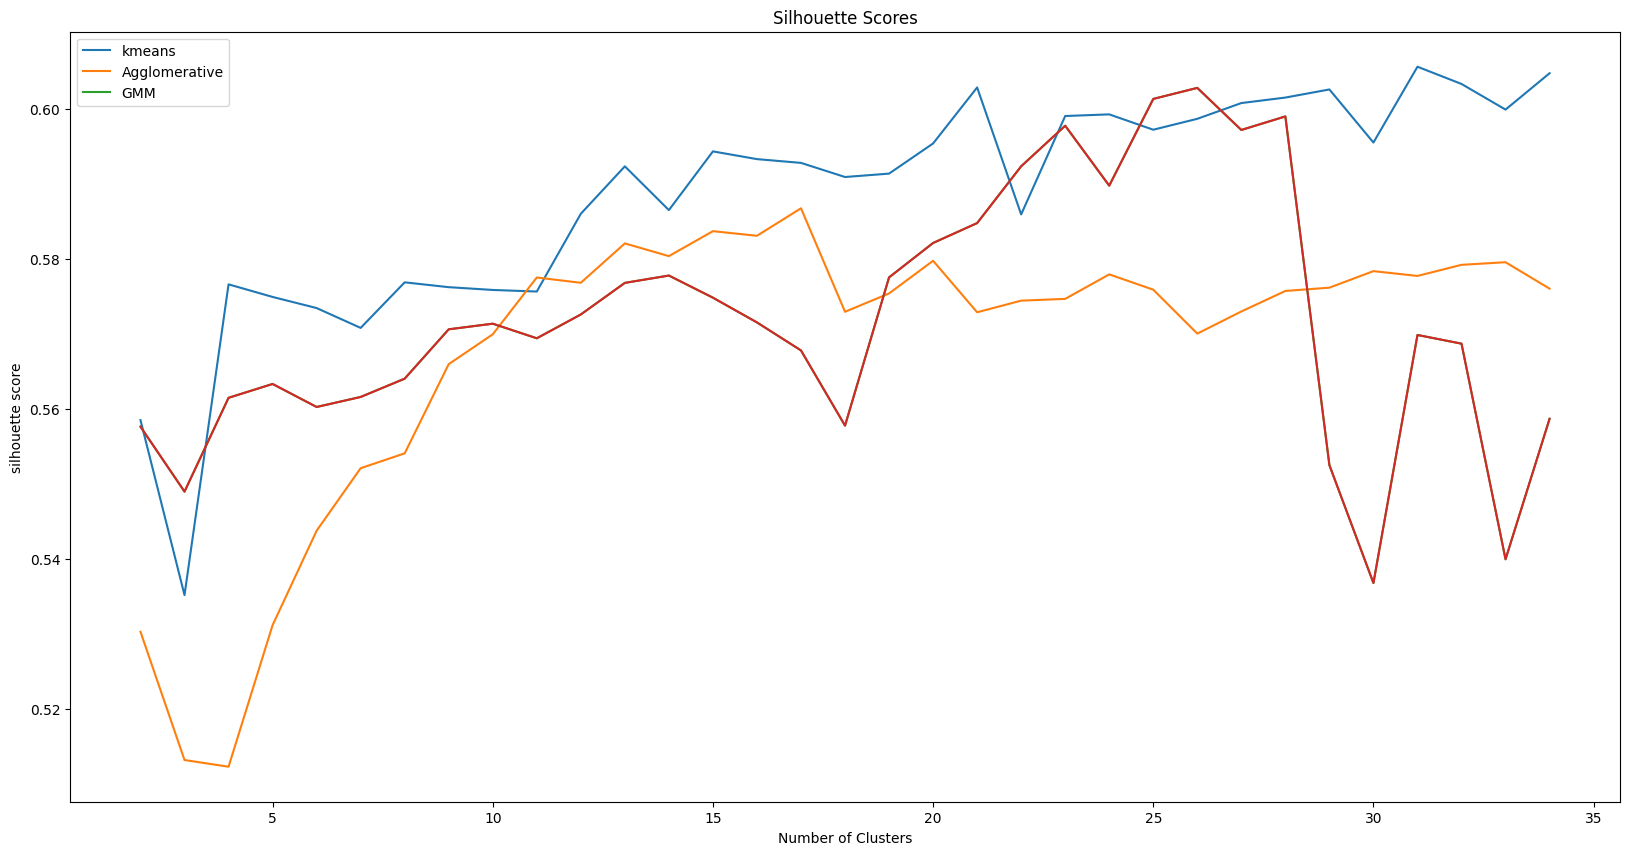

In [38]:
clusters=range(2,35,1)

# Compute the silhouette score for K means cluster within the range
scores = []
for k in clusters:
    km = KMeans(n_clusters=k,random_state=0, n_init=10)
    labels = km.fit_predict(value_at_risk.values.reshape(-1, 1))
    score = silhouette_score(value_at_risk.values.reshape(-1, 1),labels)
    scores.append(score)


plt.figure(figsize=(20,10))
plt.plot(clusters,scores)

# Compute the silhouette score for Agglomerative cluster within the range
scores = []
for k in clusters:
    ag = AgglomerativeClustering(n_clusters=k)
    labels = ag.fit_predict(value_at_risk.values.reshape(-1, 1))
    score = silhouette_score(value_at_risk.values.reshape(-1, 1),labels)
    scores.append(score)

plt.plot(clusters,scores)

# Compute the silhouette score for GMM cluster within the range
scores = []
for k in clusters:
    gm =GaussianMixture(n_components=k, random_state=42)
    labels = gm.fit_predict(value_at_risk.values.reshape(-1, 1))
    score = silhouette_score(value_at_risk.values.reshape(-1, 1),labels)
    scores.append(score)

plt.plot(clusters,scores)

plt.plot(clusters,scores)
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('silhouette score')
plt.legend(['kmeans','Agglomerative','GMM'])

### Davies-Bouldin Index

Davies-Bouldin Index K-Means: 0.48354675273016196
Davies-Bouldin Index GMM: 0.4698471703064862
Davies-Bouldin Index Agglomerative Clustering: 0.47908401452090094


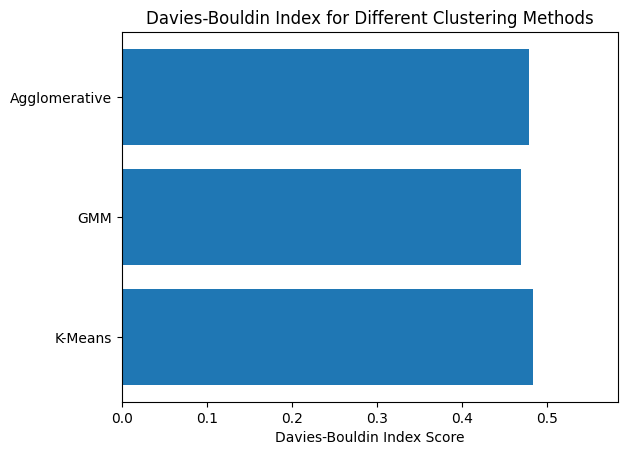

In [39]:
# Count Davies-Bouldin Index for every method of clustering
db_index_kmeans = davies_bouldin_score(value_at_risk.values.reshape(-1, 1), test1_clusters_kmeans)
db_index_gmm = davies_bouldin_score(value_at_risk.values.reshape(-1, 1), test1_clusters_gmm)
db_index_aglo = davies_bouldin_score(value_at_risk.values.reshape(-1, 1), test1_clusters_aglo)

# Display the result
print(f"Davies-Bouldin Index K-Means: {db_index_kmeans}")
print(f"Davies-Bouldin Index GMM: {db_index_gmm}")
print(f"Davies-Bouldin Index Agglomerative Clustering: {db_index_aglo}")

methods = ['K-Means', 'GMM', 'Agglomerative']
scores = [db_index_kmeans, db_index_gmm, db_index_aglo]

# Create a bar chart
plt.barh(methods, scores)
plt.xlabel('Davies-Bouldin Index Score')
plt.title('Davies-Bouldin Index for Different Clustering Methods')
plt.xlim([0, max(scores) + 0.1])  # Adjust the x-axis limits if needed

# Display the plot
plt.show()


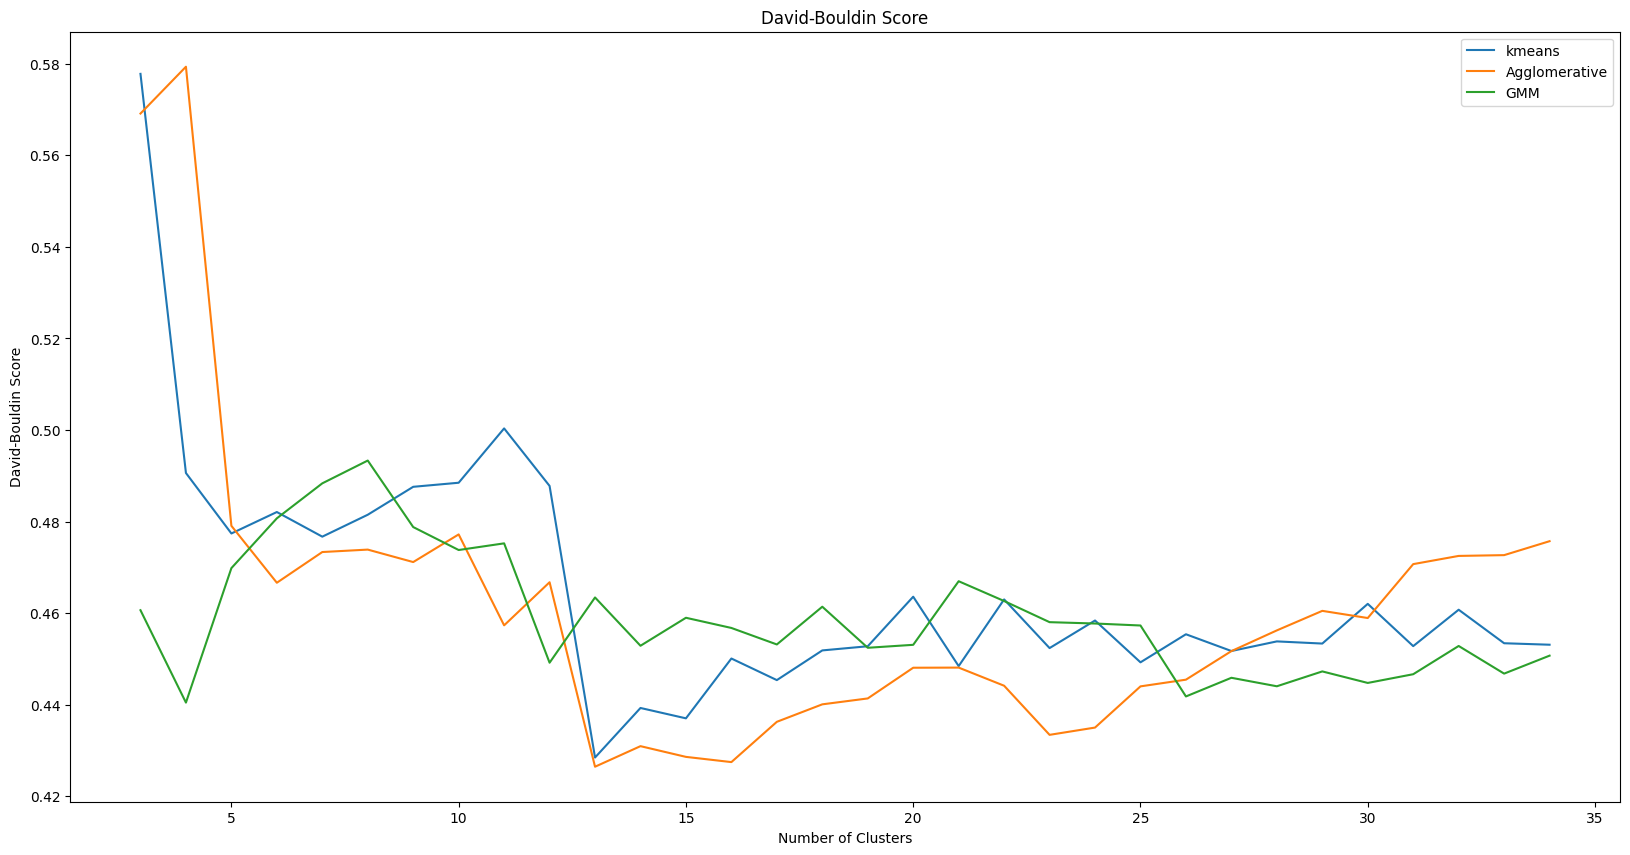

In [40]:
clusters=range(3,35,1)

# Compute the Davies Bouldin score for K means cluster within the range 
scores_dbi = []
for k in clusters:
    km = KMeans(n_clusters=k,random_state=0, n_init=10)
    labels = km.fit_predict(value_at_risk.values.reshape(-1, 1))
    score = davies_bouldin_score(value_at_risk.values.reshape(-1, 1),labels)
    scores_dbi.append(score)


plt.figure(figsize=(20,10))
plt.plot(clusters,scores_dbi)

# Compute the Davies Bouldin score for Agglomerative cluster within the range
scores_dbi = []
for k in clusters:
    ag = AgglomerativeClustering(n_clusters=k)
    labels = ag.fit_predict(value_at_risk.values.reshape(-1, 1))
    score = davies_bouldin_score(value_at_risk.values.reshape(-1, 1),labels)
    scores_dbi.append(score)

plt.plot(clusters,scores_dbi)

# Compute the Davies Bouldin score for GMM cluster within the range
scores_dbi = []
for k in clusters:
    gm =GaussianMixture(n_components=k, random_state=42)
    labels = gm.fit_predict(value_at_risk.values.reshape(-1, 1))
    score = davies_bouldin_score(value_at_risk.values.reshape(-1, 1),labels)
    scores_dbi.append(score)

plt.plot(clusters,scores_dbi)

plt.title('David-Bouldin Score')
plt.xlabel('Number of Clusters')
plt.ylabel('David-Bouldin Score')
plt.legend(['kmeans','Agglomerative','GMM'])

---
---
## **Summary**
---
---

Our results show that in our case with five clusters, Kmeans shows a better degree of similarity between the data in each cluster compared to other algorithms based on Silhouette calculations. On the other hand, when looking at the Davies-Bouldin Index (DBI), GMM shows a better level of member density in each cluster compared to the other two algorithms.

In conclusion, from our graph analysis, Kmeans seems to be the best algorithm choice due to its better consistency within each cluster when evaluated with both Silhouette and DBI metrics.